In [25]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten,MaxPooling2D, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Activation, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2

In [26]:
root_dir = r"C:\repos\Practical-ML-by-WAI\6_deep_learning\CNN\cats_and_dogs_filtered"

In [27]:
BATCH_SIZE  = 64
EPOCHS = 35

input_img_size = (128,128)
input_shape = (128,128,3)

dropout_rate = 0.5
initial_lr = 1e-3

weight_decay = 1e-4


In [28]:
# Data Augmentation
tf_generator =  tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_ds = tf_generator.flow_from_directory(
    root_dir+"/train",
    target_size=input_img_size,
    batch_size=BATCH_SIZE,
    class_mode='binary'  # or 'categorical'
)
val_ds = tf_generator.flow_from_directory(
    root_dir+"/test",
    target_size=input_img_size,
    batch_size=BATCH_SIZE,
    class_mode='binary'  # or 'categorical'
)

Found 2752 images belonging to 2 classes.
Found 248 images belonging to 2 classes.


In [29]:
# def conv_block(filters):
#     return [
#         Conv2D(filters, (3,3), padding='same', use_bias=False, kernel_regularizer=l2(weight_decay)),
#         BatchNormalization(),
#         Activation('relu'),
#         MaxPooling2D((2,2))
#     ]

# model = Sequential([
#     Input(shape=input_shape),
#     *conv_block(32),
#     *conv_block(64),
#     *conv_block(128),
#     *conv_block(256),

#     GlobalAveragePooling2D(),
#     Dense(512, activation='relu', kernel_regularizer=l2(weight_decay)),
#     Dropout(dropout_rate),
#     Dense(128, activation='relu', kernel_regularizer=l2(weight_decay)),
#     Dropout(dropout_rate),
#     Dense(1, activation='sigmoid')
# ])


In [30]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Convolution2D(32, 3, 3, input_shape = (128,128, 3), activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))
model.add(tf.keras.layers.Convolution2D(32, 3, 3, activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(units = 64, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))




c:\anaconda3\envs\3.11.13\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
optimizer = Adam(learning_rate=initial_lr)

model.compile(loss='binary_crossentropy',
              optimizer = optimizer,
              metrics = ['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 42, 42, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,705 (112.13 KB)

 Trainable params: 28,705 (112.13 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Static Learning Rate Scheduler
base_learning_rate = 1e-3
def static_lr_scheduler(epoch, lr):
    total_epochs = EPOCHS
    
    check_1 = int(total_epochs*0.9)
    check_2 = int(total_epochs*0.7)
    check_3 = int(total_epochs*0.5)
    # check_4 = int(total_epochs*0.3)

    if epoch > check_1:
        lr =  1e-5 # 0.000001
    elif  epoch > check_2:
        lr = 1e-4
    elif  epoch > check_3:
        lr = 1e-3

    else:
        lr = 1e-2

    print("[+] Current LR rate : {}".format(lr))
    return lr

curstom_lr_callback = tf.keras.callbacks.LearningRateScheduler(static_lr_scheduler)

In [33]:
# TensorBoard Callback

import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,        # Log histograms every epoch (useful for weights, biases)
    write_graph=True,        # Visualize the model graph
    write_images=False,      # Log weight images (can be heavy)
    update_freq='epoch',     # 'batch' or 'epoch'
    profile_batch=0          # Set >0 to enable performance profiling
)

In [34]:
# history = model.fit(train_ds,epochs=EPOCHS, validation_data=val_ds,verbose=1)
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[
        curstom_lr_callback,
        tensorboard_callback
    ]
)

[+] Current LR rate : 0.01
Epoch 1/35
43/43 ━━━━━━━━━━━━━━━━━━━━ 26s 531ms/step - accuracy: 0.5164 - loss: 0.6951 - val_accuracy: 0.4597 - val_loss: 0.6998 - learning_rate: 0.0100
[+] Current LR rate : 0.01
Epoch 2/35
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 522ms/step - accuracy: 0.4978 - loss: 0.6937 - val_accuracy: 0.4597 - val_loss: 0.6937 - learning_rate: 0.0100
[+] Current LR rate : 0.01
Epoch 3/35
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 533ms/step - accuracy: 0.5124 - loss: 0.6935 - val_accuracy: 0.4597 - val_loss: 0.6959 - learning_rate: 0.0100
[+] Current LR rate : 0.01
Epoch 4/35
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 506ms/step - accuracy: 0.4985 - loss: 0.6934 - val_accuracy: 0.4597 - val_loss: 0.6941 - learning_rate: 0.0100
[+] Current LR rate : 0.01
Epoch 5/35
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 528ms/step - accuracy: 0.4938 - loss: 0.6938 - val_accuracy: 0.4597 - val_loss: 0.6944 - learning_rate: 0.0100
[+] Current LR rate : 0.01
Epoch 6/35
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 514ms/step - accuracy: 0.4920 -

In [38]:
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 463ms/step - accuracy: 0.5484 - loss: 0.6812
Validation Loss: 0.6812
Validation Accuracy: 0.5484


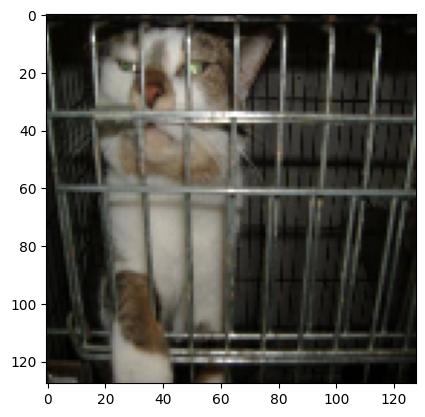

In [39]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = root_dir + "/test/cats/cat.2366.jpg"

img = image.load_img(img_path, target_size=input_img_size)
img_array = image.img_to_array(img)  # shape: (_, _, 3)
img_array = img_array / 255.0        # normalize

img_array = np.expand_dims(img_array, axis=0)  # shape: (1, _, _, 3)
plt.imshow(img_array[0])  # Display the image

In [41]:
class_names = train_ds.class_indices

# Convert to dict
class_indices = {name: idx for idx, name in enumerate(class_names)}
print("Class names found:", class_indices)

Class names found: {'cats': 0, 'dogs': 1}


In [44]:
prediction = model.predict(img_array)[0][0]
class_name = "dogs" if prediction > 0.5 else "cats"

print(f"Predicted class: {class_name} with confidence {prediction:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Predicted class: dogs with confidence 0.59


### Model Saving

In [45]:
import os
from dotenv import load_dotenv
load_dotenv()

ML_Summer_School_ID = os.getenv('ML_Summer_School_ID')
print("Your Sudent ID is: " + ML_Summer_School_ID)

Your Sudent ID is: ML017_MyoThet


In [46]:
model.save(f'./binary_classification/{ML_Summer_School_ID}_model.h5')

In [48]:
import json
# Save class names to a text file
with open(f'./binary_classification/{ML_Summer_School_ID}_class_indices.json', 'w') as f:
    class_names = train_ds.class_indices

    # Convert to dict
    class_indices = {name: idx for idx, name in enumerate(class_names)}
    json.dump(class_indices, f)
